<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#결측치-확인" data-toc-modified-id="결측치-확인-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>결측치 확인</a></span></li><li><span><a href="#일변량-시계열---item_id,-month" data-toc-modified-id="일변량-시계열---item_id,-month-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>일변량 시계열 - item_id, month</a></span><ul class="toc-item"><li><span><a href="#Decompose" data-toc-modified-id="Decompose-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Decompose</a></span></li><li><span><a href="#정상성-검정-및-차분-연산-결정" data-toc-modified-id="정상성-검정-및-차분-연산-결정-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>정상성 검정 및 차분 연산 결정</a></span></li><li><span><a href="#시계열정상성-만들기" data-toc-modified-id="시계열정상성-만들기-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>시계열정상성 만들기</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Simple-Exponetial-Smoothing" data-toc-modified-id="Simple-Exponetial-Smoothing-1.2.4.1"><span class="toc-item-num">1.2.4.1&nbsp;&nbsp;</span>Simple Exponetial Smoothing</a></span></li><li><span><a href="#Holt's-winter" data-toc-modified-id="Holt's-winter-1.2.4.2"><span class="toc-item-num">1.2.4.2&nbsp;&nbsp;</span>Holt's winter</a></span></li><li><span><a href="#ARMA" data-toc-modified-id="ARMA-1.2.4.3"><span class="toc-item-num">1.2.4.3&nbsp;&nbsp;</span>ARMA</a></span></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-1.2.4.4"><span class="toc-item-num">1.2.4.4&nbsp;&nbsp;</span>LSTM</a></span></li></ul></li></ul></li></ul></li></ul></div>

In [214]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

import datetime

# Time Series
from statsmodels.tsa.stattools import adfuller # 정상성 검정 - adf test 
import statsmodels.api as sm # decomposition
import statsmodels.tsa.api as smt # ts result

# Time Series Modeling
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# RNN
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam, RMSprop, SGD

# score
from sklearn.metrics import mean_squared_error as mse
import scipy.stats as st # stats


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


**Purpose**  
매장에 따른 상품의 다음달(2015년 11월) 판매량을 예측한다.  
데이터는 일별 매출을 기록하고 있기때문에 월별 판매량으로 바꾸어 탐색한다.

**Data Info**  
러시아 IT사 [1C Company](http://1c.ru/eng/title.html)가 제공한 상품 판매 데이터.
- sales_train.csv : 2013년 1월부터 2015년 10월까지의 상품 판매 정보
- test.csv : 2015년 11월 매출 예측
- sample_submission.csv : 제출 파일 양식
- items.csv : 상품 정보
- item_categories.csv : 상품 카테고리 정보
- shops.csv : 매장 정보

**Data Description**
- ID : (매장, 상품) 튜플(Tuple) 형식 *train_v2에서 사라진것으로 보임*
- shop_id : 매장 ID
- item_id - 상품 ID
- item_category_id - 상품 카테고리 ID
- item_cnt_day - 판매량
- item_price - 현재 상품 가격
- date - 날짜
- date_block_num - 2013년 1월부터 2015년 10월까지 순서대로 번호를 할당한 값.(ex 2013년 1월 :1, 2015년 10월:33)
- item_name - 상품 이름
- shop_name - 매장 이름
- item_category_name - 상품 가테고리 이름

**Reference**  
* [A Gentle Introduction to Handling a Non-Stationary Time Series in Python, Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)

In [38]:
# 데이터 불러오기
df_train = pd.read_csv('data/sales_train_v2.csv')
df_items = pd.read_csv('data/items.csv')
df_shops = pd.read_csv('data/shops.csv')
df_item_categories = pd.read_csv('data/item_categories.csv')
df_test = pd.read_csv('data/test.csv')
df_sub = pd.read_csv('data/sample_submission.csv')

## EDA

### 결측치 확인

In [8]:
df_train.isnull().mean()

date              0.0
date_block_num    0.0
shop_id           0.0
item_id           0.0
item_price        0.0
item_cnt_day      0.0
dtype: float64

In [9]:
df_test.isnull().mean()

ID         0.0
shop_id    0.0
item_id    0.0
dtype: float64

### 일변량 시계열 - item_id, month

* 월별 상품 판매량 평균은 매년 12월 최댓값을 기록한다.(2013년 12월 : 22, 2014년 12월 : 26)
    * 추세 : 약간 상승
    * 계절성 : 12달(1년)

In [53]:
tmp = df_train.groupby(by = ['date_block_num','item_id'])['item_cnt_day'].sum()
mean_sales = []

# 월별 판매량 평균
for i in range(0,34): mean_sales.append(tmp.loc[i].mean())

In [54]:
date_range = df_train['date'].apply(lambda x:x[6:]+'-'+x[3:5]).unique()

In [55]:
mean_sales = pd.Series(mean_sales,index = date_range)

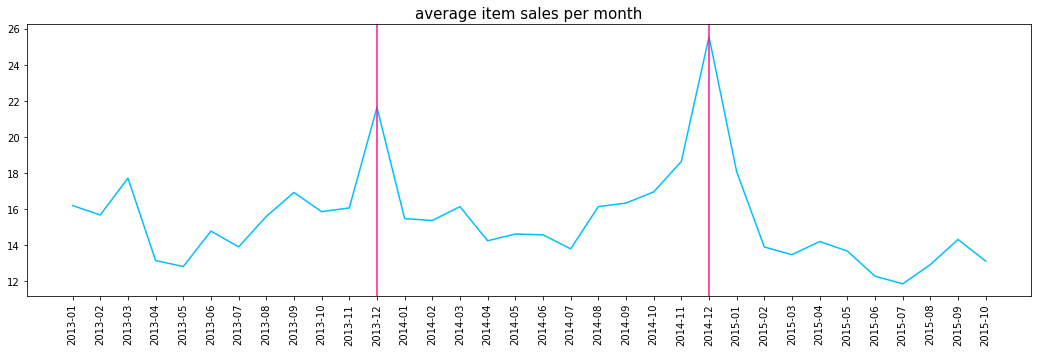

In [106]:
# 월별 상품 판매량 평균 그래프
plt.figure(figsize = (18,5))
sb.lineplot(x=mean_sales.index, y= mean_sales,color = 'deepskyblue')
plt.title('average item sales per month',fontsize = 15)
# 최댓값 표시
plt.axvline(x='2013-12',color = 'deeppink')
plt.axvline(x='2014-12',color = 'deeppink')

plt.xticks(rotation=90)
plt.show()

#### Decompose

* additive :  y(t) = Level + Trend + Seasonality + Noise
* multiplicative : y(t) = Level * Trend * Seasonality * Noise

In [95]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

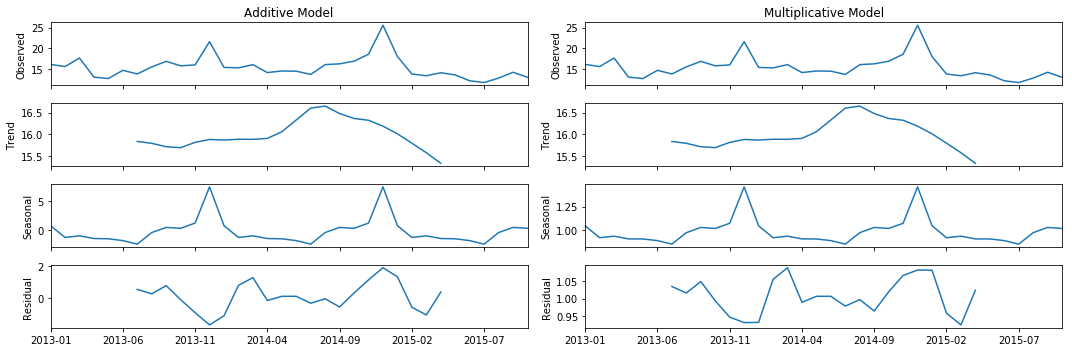

In [96]:
fig, ax = plt.subplots(ncols = 2,nrows=4,sharex = True,figsize = (15,5))
add_model = sm.tsa.seasonal_decompose(mean_sales,freq = 12, model = 'additive')
mul_model = sm.tsa.seasonal_decompose(mean_sales,freq = 12, model = 'multiplicative')
plotseasonal(add_model, ax[:,0])
ax[0,0].set_title('Additive Model')
plotseasonal(mul_model, ax[:,1])
ax[0,1].set_title('Multiplicative Model')

plt.tight_layout()
plt.show()

#### 정상성 검정 및 차분 연산 결정

* Augmented Dicky-Fuller test
    * h0 : 정상시계열이다
    * h1 : 비정상 시계열이다
* regression nt :  추세가 없는 시계열

In [83]:
# adf test
def adf_test(ts):
    # AIC로 Autolag
    res_adfuller = adfuller(ts, autolag = 'AIC',regression ='nc')
    res = pd.Series(res_adfuller[0:4],index = ['검정통계량','p-value','Lags Used','사용한 관측치 개수'])
    for key,val in res_adfuller[4].items():
        res[f'Critical Value ({key})'] = val
    print(res)

In [84]:
adf_test(mean_sales)

검정통계량                   -0.674341
p-value                  0.423417
Lags Used                0.000000
사용한 관측치 개수              33.000000
Critical Value (1%)     -2.636822
Critical Value (5%)     -1.951361
Critical Value (10%)    -1.610558
dtype: float64


#### 시계열정상성 만들기

* first difference for linear trend; 
* log for non-linear trend; 
* log seasonal difference for seasonality

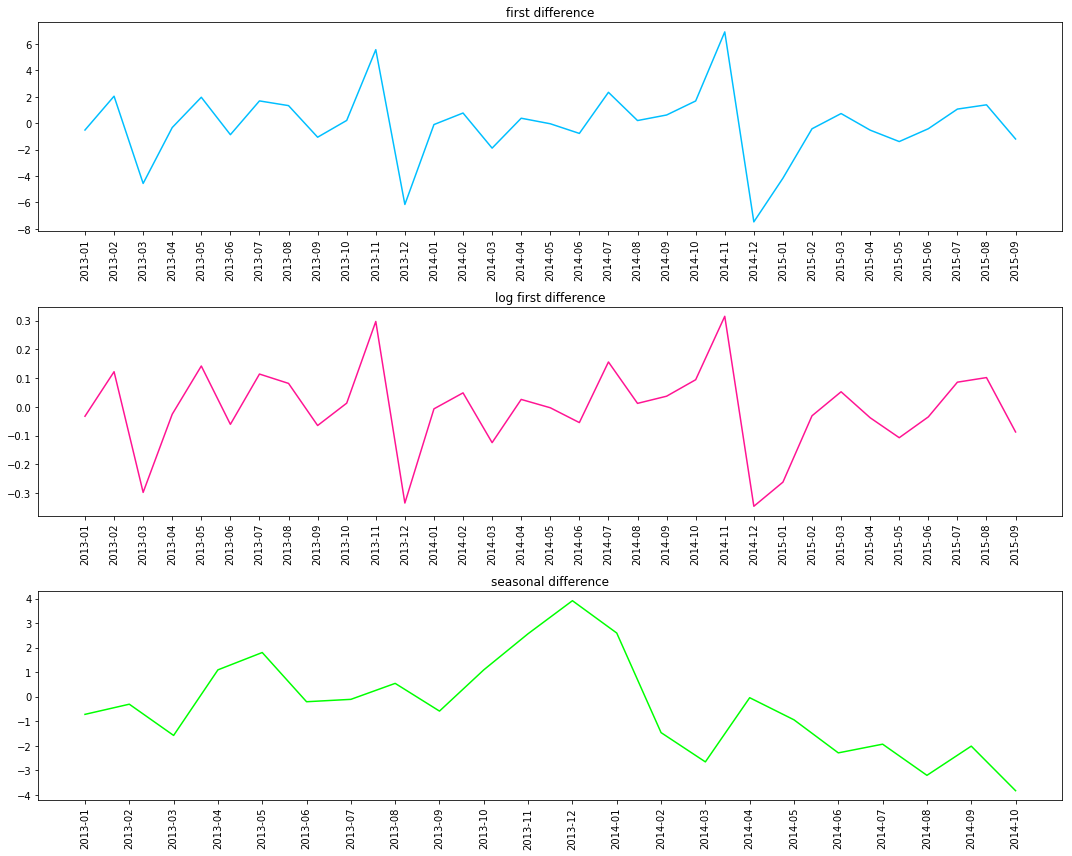

In [501]:
# first difference
fig,ax = plt.subplots(3,1,figsize = (15,12))

mean_sales_diff = mean_sales-mean_sales.shift(1)
ax[0].plot(mean_sales_diff.dropna(),color = 'deepskyblue')
ax[0].set_title('first difference')
ax[0].set_xticklabels(mean_sales_diff.index,rotation = 90)

# log first difference
mean_sales_log = mean_sales.apply(lambda x : np.log(x))
mean_sales_log_diff = mean_sales_log-mean_sales_log.shift(1)
ax[1].plot(mean_sales_log_diff.dropna(),color = 'deeppink')
ax[1].set_title('log first difference')
ax[1].set_xticklabels(mean_sales_log_diff.index,rotation = 90)

# seasonal difference
mean_sales_seasonal = mean_sales-mean_sales.shift(12)
ax[2].plot(mean_sales_seasonal.dropna(),color = 'lime')
ax[2].set_title('seasonal difference')
ax[2].set_xticklabels(mean_sales_seasonal.index,rotation = 90)

plt.tight_layout()
plt.show()

In [ ]:
# log_first_difference


In [426]:
# log seasonal difference

#### Modeling

* **RMSE**
    * simple exponential smoothing
        * avg model : 3.3968642171464998 
        * Naive : 1.1411059345822245
        * alpha model : 1.528143542677852
    * holt's winter : 1.0873225972560498
    * ARMA(1,2) : 3.0261873268046657
    * LSTM : 3.076844536682429


##### Simple Exponetial Smoothing

$$
Forecast = Weight(t)Y(t) + Weight(t-1)Y(t-1) + Weight(t-2) Y(t-2) + ... + (1-α)^n Yn
$$

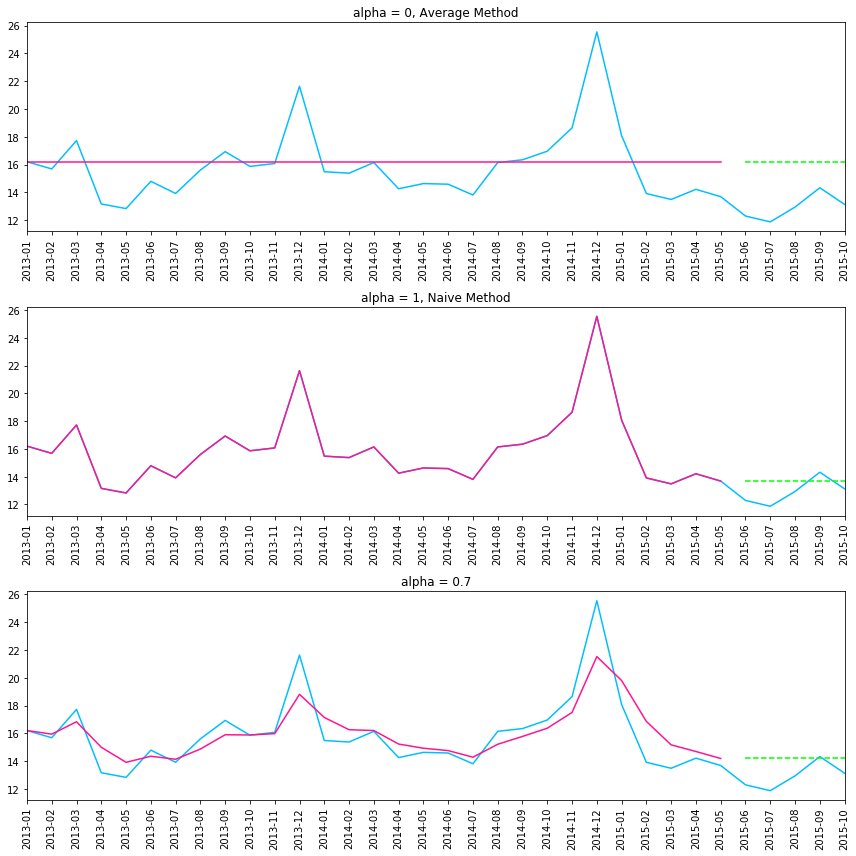

rmse
-avg model : 3.3968642171464998 
-Naive : 1.1411059345822245
-alpha model : 1.528143542677852


In [173]:
# train : 2013-1 ~ 2015-5
# test : 2015-6 ~ 2016-10

fig,ax = plt.subplots(3,1,figsize = (12,12))
labels =  mean_sales.index.tolist()

# Modeling
avg_model = SimpleExpSmoothing(mean_sales[:-5]).fit(smoothing_level=0, optimized=False)
naive_model = SimpleExpSmoothing(mean_sales[:-5]).fit(smoothing_level=1, optimized=False)
alpha_model = SimpleExpSmoothing(mean_sales[:-5]).fit(smoothing_level=.5, optimized=False)

# insample test
y_pred_avg = avg_model.predict(start=29,end=33)
y_pred_naive = naive_model.predict(start=29,end=33)
y_pred_alpha= alpha_model.predict(start=29,end=33)

avg_rmse = np.sqrt(mse(mean_sales[-5:].values,y_pred_avg))
naive_rmse = np.sqrt(mse(mean_sales[-5:].values,y_pred_naive))
alpha_rmse = np.sqrt(mse(mean_sales[-5:].values,y_pred_alpha))

# plot
insample_pred_index = ['2015-06','2015-07','2015-08','2015-09','2015-10']
y_pred_avg_plot = pd.Series(y_pred_avg,index = insample_pred_index)
y_pred_naive_plot = pd.Series(y_pred_naive,index = insample_pred_index)
y_pred_alpha_plot = pd.Series(y_pred_alpha,index = insample_pred_index)

# Average
res = avg_model.level
ax[0].plot(mean_sales,color = 'deepskyblue')
res.plot(ax=ax[0],color = 'deeppink')
ax[0].plot(y_pred_avg_plot,color = 'lime',linestyle = 'dashed')
ax[0].set_xticklabels(labels,rotation = 90)
ax[0].set_title('alpha = 0, Average Method')

# Naive
res = naive_model.level
ax[1].plot(mean_sales,color = 'deepskyblue')
res.plot(ax=ax[1],color = 'deeppink')
ax[1].plot(y_pred_naive_plot,color = 'lime',linestyle = 'dashed')
ax[1].set_xticklabels(labels,rotation = 90)
ax[1].set_title('alpha = 1, Naive Method')


#alpha = .7
res = alpha_model.level
ax[2].plot(mean_sales,color = 'deepskyblue')
res.plot(ax=ax[2],color = 'deeppink')
ax[2].plot(y_pred_alpha_plot,color = 'lime',linestyle = 'dashed')
ax[2].set_xticklabels(labels,rotation = 90)
ax[2].set_title('alpha = 0.7')

plt.tight_layout()
plt.show()

print(f'rmse\n-avg model : {avg_rmse} \n-Naive : {naive_rmse}\n-alpha model : {alpha_rmse}')

##### Holt's winter

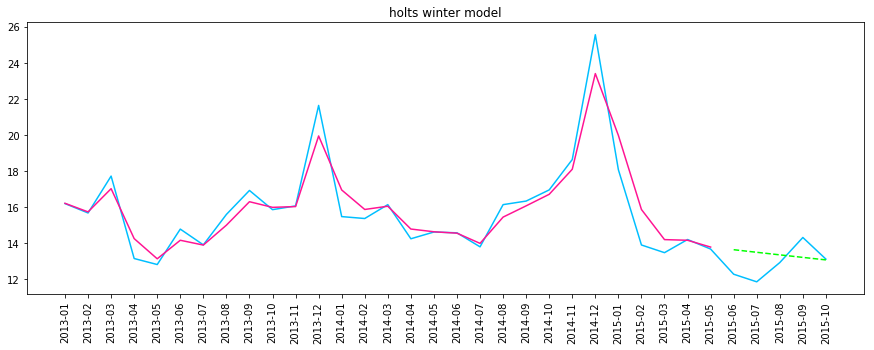

holt model : 1.0873225972560498


In [175]:
plt.figure(figsize = (15,5))

# smoothing_level : alpha
# smoothing_slope : beta

holt_model = Holt(mean_sales[:-5].values,exponential = True).fit(smoothing_level = 0.7, smoothing_slope = 0.1, optimized = True)
y_pred_holt = holt_model.predict(start=29,end=33)

insample_pred_index = ['2015-06','2015-07','2015-08','2015-09','2015-10']
y_pred_holt_plot = pd.Series(y_pred_holt,index = insample_pred_index)

plt.plot(mean_sales,color = 'deepskyblue')
plt.plot(holt_model.level,color = 'deeppink')
plt.plot(y_pred_holt_plot,color = 'lime',linestyle = 'dashed')
plt.title('holts winter model')
plt.xticks(rotation = 90)
plt.show()

holt_rmse = np.sqrt(mse(mean_sales[-5:],y_pred_holt))
print(f'holt model : {holt_rmse}')

##### ARMA

In [182]:
# AR, Autocorrlation, partial Autocorrelation, QQ plot, Probablilty plot
def ts_res_plot(y, lags, title, figsize=(10, 8), style='bmh'):
    plt.figure(figsize = figsize)
    layout = (3,2)
    
    # y를 Series로 변경
    if not isinstance(y,pd.Series): y= pd.Series(y)
    
    # axes 설정
    ts_ax = plt.subplot2grid(layout, (0,0),colspan =2)
    acf_ax = plt.subplot2grid(layout,(1,0))
    pacf_ax = plt.subplot2grid(layout,(1,1))
    qq_ax = plt.subplot2grid(layout,(2,0))
    pp_ax = plt.subplot2grid(layout,(2,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title) # ts
    smt.graphics.plot_acf(y,lags = lags,ax = acf_ax, alpha=.5) # acf
    smt.graphics.plot_pacf(y,lags = lags, ax = pacf_ax, alpha = .5) # pacf
    sm.qqplot(y, line = 's', ax = qq_ax) # qq 
    qq_ax.set_title('QQ plot')
    st.probplot(y,sparams = (y.mean(), y.std()),plot = pp_ax) # prob
    plt.tight_layout()   

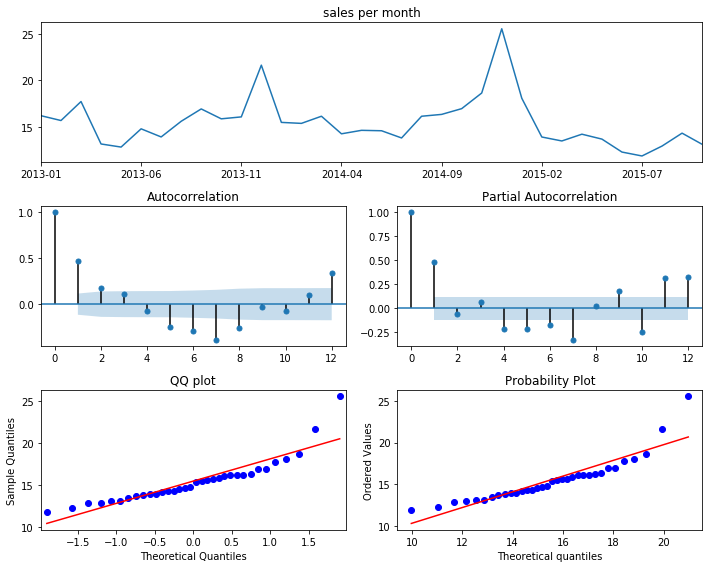

In [183]:
ts_res_plot(mean_sales,lags = 12,title = 'sales per month')

In [184]:
# AIC로 최적 order 탐색
# AIC가 최소가 되는 order 선정

best_aic = np.inf
best_order = None
best_model  =None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(mean_sales[:-5], order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_model = tmp_mdl
        except: continue
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 148.23954 | order: (1, 2)


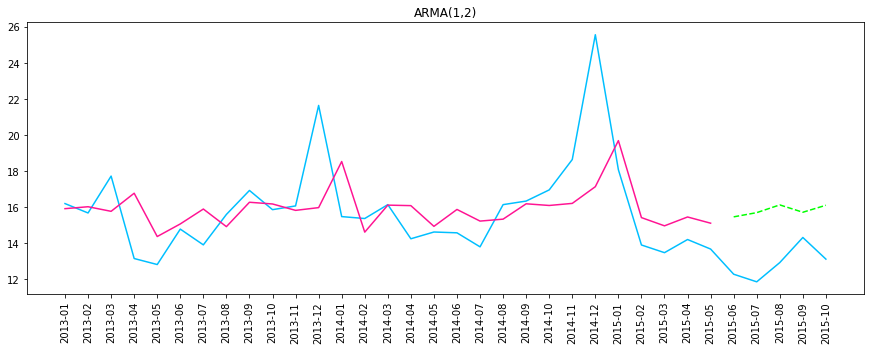

ARMA model : 3.0261873268046657


In [213]:
plt.figure(figsize = (15,5))

# smoothing_level : alpha
# smoothing_slope : beta

arima_model_best = smt.ARMA(mean_sales[:-5],order=(1,2))
model_fit_best = arima_model_best.fit()
y_pred_arima_best = model_fit_best.forecast(5)[0]

insample_pred_index = ['2015-06','2015-07','2015-08','2015-09','2015-10']
y_pred_arima_best_plot = pd.Series(y_pred_arima_best,index = insample_pred_index)

plt.plot(mean_sales,color = 'deepskyblue')
plt.plot(model_fit_best.fittedvalues,color = 'deeppink')
plt.plot(y_pred_arima_best_plot,color = 'lime',linestyle = 'dashed')
plt.title('ARMA(1,2)')
plt.xticks(rotation = 90)
plt.show()

y_pred_arima_best = model_fit_best.forecast(5)[0]
y_rmse_arima_best = np.sqrt(mse(mean_sales[-5:].values,y_pred_arima_best))
print(f'ARMA model : {y_rmse_arima_best}')

##### LSTM

In [513]:
# original data
mean_sales_train= mean_sales[:-5].values.reshape(1,-1,1) # batch, time-series 길이, 변수

# first difference
mean_sales_diff_train = mean_sales_diff.dropna()[:-5].values.reshape(1,-1,1)

In [566]:
n_input = 1     # 스칼라 시계열 입력.
n_neurons = 300 # 셀별 뉴런의 개수.
n_output = 1    # 스칼라 시계열 출력.

In [567]:
model = Sequential([
    SimpleRNN(units=n_neurons,return_sequences=True, input_shape = (None,n_input)),
    LSTM(units=n_neurons,return_sequences=True, input_shape=(None, n_input)),
    TimeDistributed(Dense(units=n_output, activation="linear"))
])

In [568]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, None, 300)         90600     
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 300)         721200    
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 1)           301       
Total params: 812,101
Trainable params: 812,101
Non-trainable params: 0
_________________________________________________________________


In [569]:
n_epochs = 500                 # 에포크의 총 길이.
n_batch_size = 1                # 배치의 크기 (단 하나의 시계열 데이터).
learn_rate = 0.0002             # 학습속도.  

In [570]:
# 손실함수, 최적화함수
my_optimizer=Adam(lr=learn_rate)
model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

In [571]:
# original
my_summary = model.fit(mean_sales_train[:,:-1,:], mean_sales_train[:,1:,:], epochs=n_epochs, batch_size = n_batch_size, verbose = 1)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 242.0101 - mean_squared_error: 242.0101
Epoch 2/500
1/1 [==============================] - 0s 66ms/step - loss: 219.6950 - mean_squared_error: 219.6950
Epoch 3/500
1/1 [==============================] - 0s 67ms/step - loss: 196.0283 - mean_squared_error: 196.0283
Epoch 4/500
1/1 [==============================] - 0s 52ms/step - loss: 173.5136 - mean_squared_error: 173.5136
Epoch 5/500
1/1 [==============================] - 0s 63ms/step - loss: 153.3150 - mean_squared_error: 153.3150
Epoch 6/500
1/1 [==============================] - 0s 67ms/step - loss: 135.4253 - mean_squared_error: 135.4253
Epoch 7/500
1/1 [==============================] - 0s 69ms/step - loss: 119.5681 - mean_squared_error: 119.5681
Epoch 8/500
1/1 [==============================] - 0s 75ms/step - loss: 105.4826 - mean_squared_error: 105.4826
Epoch 9/500
1/1 [==============================] - 0s 71ms/step - loss: 92.9500 - mean_squared_error: 92.9

Epoch 75/500
1/1 [==============================] - 0s 62ms/step - loss: 10.5874 - mean_squared_error: 10.5874
Epoch 76/500
1/1 [==============================] - 0s 72ms/step - loss: 10.5461 - mean_squared_error: 10.5461
Epoch 77/500
1/1 [==============================] - 0s 71ms/step - loss: 10.5059 - mean_squared_error: 10.5059
Epoch 78/500
1/1 [==============================] - 0s 64ms/step - loss: 10.4667 - mean_squared_error: 10.4667
Epoch 79/500
1/1 [==============================] - 0s 71ms/step - loss: 10.4284 - mean_squared_error: 10.4284
Epoch 80/500
1/1 [==============================] - 0s 67ms/step - loss: 10.3906 - mean_squared_error: 10.3906
Epoch 81/500
1/1 [==============================] - 0s 71ms/step - loss: 10.3533 - mean_squared_error: 10.3533
Epoch 82/500
1/1 [==============================] - 0s 85ms/step - loss: 10.3162 - mean_squared_error: 10.3162
Epoch 83/500
1/1 [==============================] - 0s 62ms/step - loss: 10.2791 - mean_squared_error: 10.2791
E

Epoch 150/500
1/1 [==============================] - 0s 66ms/step - loss: 8.0343 - mean_squared_error: 8.0343
Epoch 151/500
1/1 [==============================] - 0s 59ms/step - loss: 8.0027 - mean_squared_error: 8.0027
Epoch 152/500
1/1 [==============================] - 0s 59ms/step - loss: 7.9715 - mean_squared_error: 7.9715
Epoch 153/500
1/1 [==============================] - 0s 62ms/step - loss: 7.9390 - mean_squared_error: 7.9390
Epoch 154/500
1/1 [==============================] - 0s 61ms/step - loss: 7.9080 - mean_squared_error: 7.9080
Epoch 155/500
1/1 [==============================] - 0s 63ms/step - loss: 7.8758 - mean_squared_error: 7.8758
Epoch 156/500
1/1 [==============================] - 0s 59ms/step - loss: 7.8437 - mean_squared_error: 7.8437
Epoch 157/500
1/1 [==============================] - 0s 68ms/step - loss: 7.8126 - mean_squared_error: 7.8126
Epoch 158/500
1/1 [==============================] - 0s 63ms/step - loss: 7.7803 - mean_squared_error: 7.7803
Epoch 159/

Epoch 225/500
1/1 [==============================] - 0s 62ms/step - loss: 4.7646 - mean_squared_error: 4.7646
Epoch 226/500
1/1 [==============================] - 0s 67ms/step - loss: 4.7186 - mean_squared_error: 4.7186
Epoch 227/500
1/1 [==============================] - 0s 67ms/step - loss: 4.6734 - mean_squared_error: 4.6734
Epoch 228/500
1/1 [==============================] - 0s 64ms/step - loss: 4.6292 - mean_squared_error: 4.6292
Epoch 229/500
1/1 [==============================] - 0s 67ms/step - loss: 4.5858 - mean_squared_error: 4.5858
Epoch 230/500
1/1 [==============================] - 0s 75ms/step - loss: 4.5434 - mean_squared_error: 4.5434
Epoch 231/500
1/1 [==============================] - 0s 63ms/step - loss: 4.5019 - mean_squared_error: 4.5019
Epoch 232/500
1/1 [==============================] - 0s 69ms/step - loss: 4.4621 - mean_squared_error: 4.4621
Epoch 233/500
1/1 [==============================] - 0s 68ms/step - loss: 4.4230 - mean_squared_error: 4.4230
Epoch 234/

Epoch 300/500
1/1 [==============================] - 0s 65ms/step - loss: 2.8298 - mean_squared_error: 2.8298
Epoch 301/500
1/1 [==============================] - 0s 55ms/step - loss: 2.8055 - mean_squared_error: 2.8055
Epoch 302/500
1/1 [==============================] - 0s 51ms/step - loss: 2.7859 - mean_squared_error: 2.7859
Epoch 303/500
1/1 [==============================] - 0s 66ms/step - loss: 2.7712 - mean_squared_error: 2.7712
Epoch 304/500
1/1 [==============================] - 0s 65ms/step - loss: 2.7607 - mean_squared_error: 2.7607
Epoch 305/500
1/1 [==============================] - 0s 70ms/step - loss: 2.7435 - mean_squared_error: 2.7435
Epoch 306/500
1/1 [==============================] - 0s 62ms/step - loss: 2.7178 - mean_squared_error: 2.7178
Epoch 307/500
1/1 [==============================] - 0s 70ms/step - loss: 2.6931 - mean_squared_error: 2.6931
Epoch 308/500
1/1 [==============================] - 0s 64ms/step - loss: 2.6768 - mean_squared_error: 2.6768
Epoch 309/

Epoch 375/500
1/1 [==============================] - 0s 51ms/step - loss: 1.6514 - mean_squared_error: 1.6514
Epoch 376/500
1/1 [==============================] - 0s 52ms/step - loss: 1.6620 - mean_squared_error: 1.6620
Epoch 377/500
1/1 [==============================] - 0s 52ms/step - loss: 1.6196 - mean_squared_error: 1.6196
Epoch 378/500
1/1 [==============================] - 0s 57ms/step - loss: 1.5633 - mean_squared_error: 1.5633
Epoch 379/500
1/1 [==============================] - 0s 56ms/step - loss: 1.5465 - mean_squared_error: 1.5465
Epoch 380/500
1/1 [==============================] - 0s 55ms/step - loss: 1.5641 - mean_squared_error: 1.5641
Epoch 381/500
1/1 [==============================] - 0s 53ms/step - loss: 1.5666 - mean_squared_error: 1.5666
Epoch 382/500
1/1 [==============================] - 0s 52ms/step - loss: 1.5231 - mean_squared_error: 1.5231
Epoch 383/500
1/1 [==============================] - 0s 53ms/step - loss: 1.4914 - mean_squared_error: 1.4914
Epoch 384/

Epoch 450/500
1/1 [==============================] - 0s 66ms/step - loss: 0.9249 - mean_squared_error: 0.9249
Epoch 451/500
1/1 [==============================] - 0s 62ms/step - loss: 0.9256 - mean_squared_error: 0.9256
Epoch 452/500
1/1 [==============================] - 0s 68ms/step - loss: 0.9454 - mean_squared_error: 0.9454
Epoch 453/500
1/1 [==============================] - 0s 63ms/step - loss: 0.9422 - mean_squared_error: 0.9422
Epoch 454/500
1/1 [==============================] - 0s 74ms/step - loss: 0.9478 - mean_squared_error: 0.9478
Epoch 455/500
1/1 [==============================] - 0s 71ms/step - loss: 0.9119 - mean_squared_error: 0.9119
Epoch 456/500
1/1 [==============================] - 0s 69ms/step - loss: 0.8920 - mean_squared_error: 0.8920
Epoch 457/500
1/1 [==============================] - 0s 71ms/step - loss: 0.8812 - mean_squared_error: 0.8812
Epoch 458/500
1/1 [==============================] - 0s 67ms/step - loss: 0.8841 - mean_squared_error: 0.8841
Epoch 459/

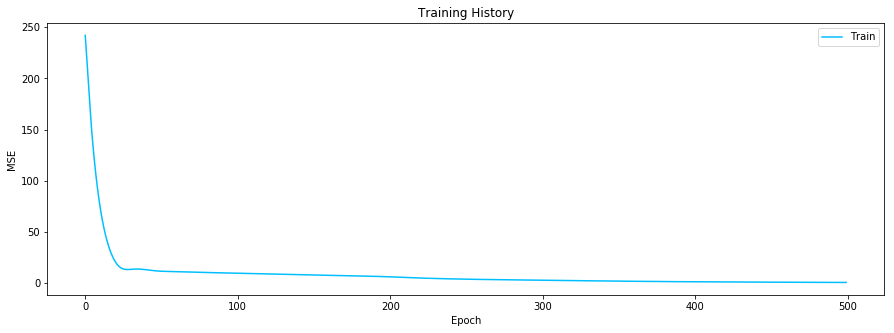

In [572]:
plt.figure(figsize = (15,5))

plt.plot(my_summary.history['mean_squared_error'], color = 'deepskyblue')
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [586]:
# tot = 34
n_ts_seed = 29
n_predict_time_steps = 5

In [587]:
# 예측 루프.
ts_seed = mean_sales[0:n_ts_seed].values
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # 적절한 shape로 변형.     
    y_pred = model.predict(X)
    y_last= y_pred[0,-1,0]             # 출력중 마지막이 바로 예측.
    ts_seed = np.concatenate((ts_seed, np.array([y_last])), axis=0)

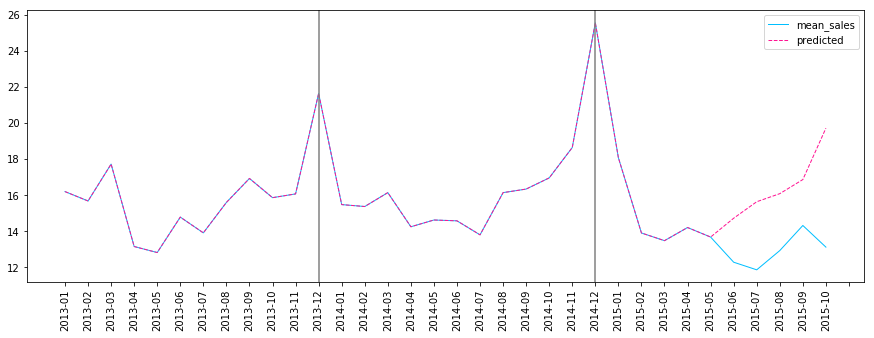

rmse : 3.9971946434757792


In [588]:
plt.figure(figsize = (15,5))

ts = ts_seed

plt.plot(mean_sales.values,c='b',linewidth=1, linestyle="-",label="mean_sales",color = 'deepskyblue')
plt.plot(ts,linewidth=1, linestyle="--",label="predicted",color = 'deeppink')
plt.xticks(ticks=range(35),labels = mean_sales.index.tolist(), rotation = 90)
plt.axvline(x=11,color = 'gray')
plt.axvline(x=23,color = 'gray')
plt.legend()
plt.show()

lstm_rmse = np.sqrt(mse(mean_sales.values[-5:],ts_seed[-5:]))
print(f'rmse : {lstm_rmse}')